### 7. Implement the convolution layer for 1 channel input and (n¿=1) channel output. Implement both forward and backward passes. Implement the flatten operation
### 8. (extra credit bonus:) generalize this for any number of input and any number of output channel. Implement both forward and backward passes

**Note:** We have directly implemented Q8 that is a Convolutional layer that can be used for any number of input and any number of output channels. Calling `Convolutional` layer with `outputChannelCnt == 1` and `inputShape[0] == 1` will solve the Q7. We have also implemented the flatten operation.

In [ ]:
# Importing libraries and important modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from keras.datasets import mnist
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

In [ ]:
# Class that represents the Convolutional Layer..
class ConvolutionalLayer():

    def __init__(self, inputShape, filterSize, outputChannelCnt):

        # Size of the input image to be convoluted.
        inputChannelCnt, inputHeight, inputWidth = inputShape

        # The no of output channels we need
        self.outputChannelCnt = outputChannelCnt

        # Storing the values to class variables.
        self.inputShape = inputShape
        self.inputChannelCnt = inputChannelCnt

        # Defining the shapes of output and kernels in terms of no of output channels , input shapes and kernel sizes.
        self.outputShape = (outputChannelCnt, inputHeight - filterSize + 1, inputWidth - filterSize + 1)
        self.kernelsShape = (outputChannelCnt, inputChannelCnt, filterSize, filterSize)

        # Initiating the Kernels and biases randomly.
        self.kernels = np.random.randn(*self.kernelsShape)
        self.biases = np.random.randn(*self.outputShape)


    def forwardPass(self, input):
        self.input = input
        self.output = np.copy(self.biases)

        # Iterating and filling the output by performing "valid" correlation operation using signal from scipy.
        for i in range(self.outputChannelCnt):
            for j in range(self.inputChannelCnt):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        
        return self.output

   
    def backwardPass(self, outputGrad, learningRate):
        
        # Initialising the partial differentiating of Kernel parameters and the input parameters.
        kernelsGrad = np.zeros(self.kernelsShape)
        inputGrad = np.zeros(self.inputShape)

        # Using the scipy library to get del(L)/del(Kernel_i) or del(L)/del(b)
        for i in range(self.outputChannelCnt):
            for j in range(self.inputChannelCnt):
                
                # Iterating and filling:
                #     The Kernels Gradient by performing "valid" correlation operation using signal from scipy.
                #     The Input Gradient by performing "full" convolution operation using signal from scipy.

                kernelsGrad[i, j] = signal.correlate2d(self.input[j], outputGrad[i], "valid")
                inputGrad[j] += signal.convolve2d(outputGrad[i], self.kernels[i, j], "full")

        # Updating the kernel weights & bias values using gradient descent.
        self.kernels -= learningRate * kernelsGrad
        self.biases -= learningRate * outputGrad
        return inputGrad

In [ ]:
# Class that reshapes the given layer to the required dimensions.
class FlattenLayer():
    def __init__(self, inputShape, outputShape):
        self.inputShape = inputShape
        self.outputShape = outputShape

    def forwardPass(self, input):
        return np.reshape(input, self.outputShape)

    def backwardPass(self, outputGrad, learningRate):
        return np.reshape(outputGrad, self.inputShape)

In [ ]:
# Class that represents the usual Dense Layer of the Neural Network.
class DenseLayer():
    def __init__(self, input_size, output_size):

        # Initialising the weights & biases randomly. 
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forwardPass(self, input):
        self.input = input

        # N = WX + B
        return np.dot(self.weights, self.input) + self.bias

    def backwardPass(self, outputGrad, learningRate):
        wGrad = np.dot(outputGrad, self.input.T)
        inputGrad = np.dot(self.weights.T, outputGrad)

        # Updating the weights & biases using gradient descent.
        self.weights -= learningRate * wGrad
        self.bias -= learningRate * outputGrad
        return inputGrad


In [ ]:
# Class that represents the activation functions of the Nueral Network.
class ActivationLayer():
    def __init__(self, activation, activationPrime):
        self.activation = activation
        self.activationPrime = activationPrime

    def forwardPass(self, input):
        self.input = input
        return self.activation(self.input)

    def backwardPass(self, outputGrad, learningRate):
        return np.multiply(outputGrad, self.activationPrime(self.input))

# Implementing the sigmoid activation function.
class Sigmoid(ActivationLayer):
    def __init__(self):

        # For forward pass
        def sigmoid(s):
            return 1 / (1 + np.exp(-s))

        # For backward pass
        def sigmoidPrime(s):
            s1 = sigmoid(s)
            return s1 * (1 - s1)

        super().__init__(sigmoid, sigmoidPrime)

# Implementing the tanh activation function.
class Tanh(ActivationLayer):
    def __init__(self):
        
        # For forward pass
        def tanh(x):
            return np.tanh(x)

         # For backward pass
        def tanhPrime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanhPrime)

### 9. Train this CNN on mnist dataset. Layer 1: Convolution layer with 16 output channels+flatten+tanh activation. Layer 2: 10 output neuron with linear activation. Softmax cross entropy loss

In [ ]:
# Y represents the True Y
# P represents the Predicted Y.

def crossEntropy(Y, P):
    return np.mean(-Y * np.log(P) - (1 - Y) * np.log(1 - P))

def crossEntropyPrime(Y, P):
    return ((1 - Y) / (1 - P) - Y / P) / np.size(Y)

In [ ]:
# Reading the MNIST Dataset & trimming the dataset so that training can be done faster.
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

# Function that preprocesses the data & trims the dataset by taking "cnt" number of samples.
def trimAndProcess(x, y, cnt):
  
    x = x[:cnt]
    y = y[:cnt]

    # Reshaping, normalising the x 
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255

    # Encoding the y.
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), 10, 1)

    return x, y

# Now, trimming the training & testing sets using the above defined functions.
xTrain, yTrain = trimAndProcess(xTrain, yTrain, 1000)
xTest, yTest = trimAndProcess(xTest, yTest, 1000)

In [ ]:
# Function that just predicts the output of the network for the given input by doing forward passes across the layers. 
def predict(nNetwork, input):
    output = input
    for layer in nNetwork:
        output = layer.forwardPass(output)
    return output

# The main function that takes the CNN and the training dataset & performs the forward & backward passes for given number of iterations. 
def train(nNetwork, xTrain, yTrain, iters, learningRate):
    lossStore = []
    for _ in range(iters):
        loss = 0
        for x, y in zip(xTrain, yTrain):

            # Performing the forwardPass
            output = predict(nNetwork, x)

            # Accumulating the loss for each sample.
            loss += crossEntropy(y, output)

            # Performing the backwardPass
            grad = crossEntropyPrime(y, output)
            for layer in reversed(nNetwork):
                grad = layer.backwardPass(grad, learningRate)

        loss /= len(xTrain)
        lossStore.append(loss)
     
    return lossStore

In [ ]:
# Defining our neural network with all the necessary layers as per the requirements.
nueralNetwork = [
           
    # 4 filters, 16 output channels
    # (1 28 28) is the input channel, height & width
    ConvolutionalLayer((1, 28, 28), 4, 16), 

    # Tanh Activation function.
    Tanh(),
    
    # Flattening the input.
    FlattenLayer((16, 25, 25), (16 * 25 * 25, 1)),

    # Dense layer with 100 output neurons.
    DenseLayer(16 * 25 * 25, 100),
    Sigmoid(),

    # Final layer with 10 output nuerons.
    DenseLayer(100, 10),
    Sigmoid()
]

# Training the CNN using the function defined earlier for 100 iters with a learning rate of 0.2
lossStore = train( nueralNetwork, xTrain, yTrain, 100, 0.2)

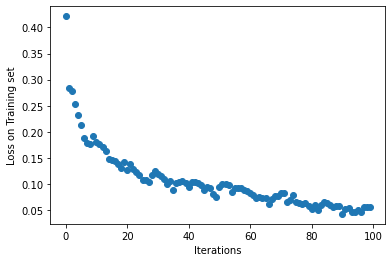

In [ ]:
plt.scatter(range(len(lossStore)),lossStore)
plt.xlabel("Iterations")
plt.ylabel("Loss on Training set")
plt.show()

#### Checking the CNN performance on test data

In [ ]:
correct_cnt = 0

for x, y in zip(xTest, yTest):
    output = predict(nueralNetwork, x)
    
    if (np.argmax(output) == np.argmax(y)):
       correct_cnt += 1

print("The percentage of the samples classified correctly is: ", (correct_cnt/len(xTest))*100,"%" )

The percentage of the samples classified correctly is:  76.2 %


### Observations:
 - We can observe that the loss on the training dataset is decreasing overall with increase in the number of iterations as per the graph plotted above. 
 - Due to the presence of numerous paramters that are being learnt in the CNN, even for training for around 1000 iterations, it is consuming a lot of time, So, we trained for just 100 iterations.  The percentage of the samples that are classified correctly by the CNN is around `76 - 85%` when trained for 100 iterations.
 - It is observable that training for even more iterations & better tuning the hyper parameter, learning rate will give an even better performance of our CNN.  

### References:
- https://towardsdatascience.com/convolutional-neural-networks-from-the-ground-up-c67bb41454e1
- https://towardsdatascience.com/a-guide-to-convolutional-neural-networks-from-scratch-f1e3bfc3e2de
- https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529